# Random Coordinate Forests

I've developed a way to increase the accuracy of ensembled classifiers. For now I'm applying it to random forests. Potentially it could be used for many other ensembles.

The idea is this: before each estimator in the ensemble is fit to the training data, apply a random change of coordinates to the features (the method of generating random changes of coordinates is taken from the reference at the end of this cell). Apply the same change of coordinates for each estimator when making predictions. For ensembles of trees, this allows each tree to learn decision regions that aren't axis-aligned rectangles. Instead, they're axis-aligned rectangles in a different, random coordinate system. But when we average the predictions of all the trees, our decision region can be much more flexible.

From a statistical perspective, what happens is that the predictions of the various trees become less correlated: not only is each tree training on a different bootstrap sample, not only is each split made based on a different set of features, but now each tree is built on a different coordinate view of the features. The less correlated the trees' predictions are, the smaller the resulting variance is: we're enhancing what makes random forests effective in the first place.

This notebook uses my `scikit-learn-supp` library available [here](https://github.com/mikebenfield/scikit-learn-supp).

Reference: Diaconis, Persi; Shahshahani, Mehrdad (1987), "The subgroup algorithm for generating uniform random variables", Prob. In Eng. And Info. Sci., 1: 15–32

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, model_selection, metrics
import sklearn_supp
from sklearn_supp.random_coordinates import RandomCoordinateForestClassifier
%matplotlib inline
random_state = np.random.RandomState(987654321)

# Let's look at a visualization with some artificial data

I'll generate an artificial binary classification problem with only two features.

In [2]:
X, y = datasets.make_classification(
    n_samples=1500,
    n_features=2,
    n_informative=2,
    n_repeated=0,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2,
    hypercube=True,
    class_sep=0.8,
    random_state=random_state,
)
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.5,
                                    stratify=y,
                                    random_state=random_state)

And write a function to plot the data and decision regions.

In [3]:
palette = sns.color_palette('deep', 10)
def plot_with_classifier(ax, est, X, y):
    from sklearn.utils.extmath import cartesian

    X = np.array(X)
    y = np.array(y)
    est.fit(X, y)

    xx = np.arange(-4, 4, 0.01)
    points = cartesian([xx, xx])
    prediction = est.predict(points)
    prediction = prediction.reshape([len(xx), len(xx)])

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    xs = X[y == 1]
    os = X[y == 0]
    ax.plot(xs[:, 0], xs[:, 1], 'o', color=palette[0], alpha=0.3)
    ax.plot(os[:, 0], os[:, 1], 'o', color=palette[2], alpha=0.3)
    ax.contourf(xx, xx, prediction.T, alpha=0.8,
                colors=[palette[4], palette[4], palette[5], palette[6]])

Below I fit `sklearn`'s `RandomForestClassifier` and my new `RandomCoordinateForestClassifier` to the training data and plot the data together with the decision regions. The blue and red balls are the data points belonging to each class. The yellow region is where the classifier will predict a new point to belong to the red class, and the light blue region is where the classifier will predict a new point to belong to the red class.

As you can see, the decision regions for `RandomForestClassifier` are pretty boxy, while those for
`RandomCoordinateForestClassifier` are smoother.

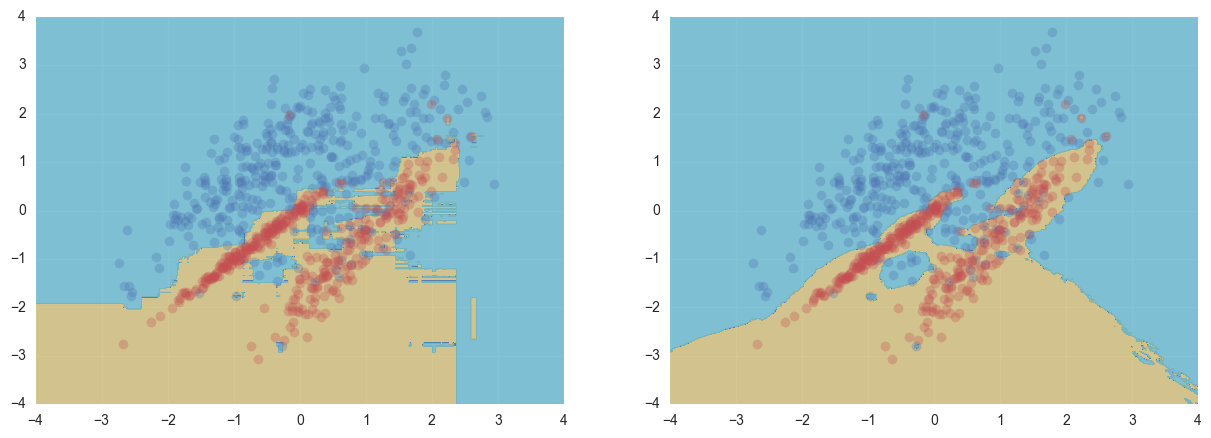

In [4]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
random_forest = RandomForestClassifier(n_estimators=300,
                                      random_state=random_state)
plot_with_classifier(ax[0], random_forest, X_train, y_train)
random_coord_forest = RandomCoordinateForestClassifier(n_estimators=300,
                                                       random_state=random_state)
plot_with_classifier(ax[1], random_coord_forest, X_train, y_train)

Below I actually make the predictions on the test data. I test each classifier, and rate its predictions by `accuracy_score`: this just tells us the proportion of correct predictions.

We get a substantial improvement from the `RandomCoordinateForest`. (This corresponds to about a 13.7% reduction in error rate.)

In [5]:
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
error_rf = 1-metrics.accuracy_score(y_test, y_pred)
random_coord_forest.fit(X_train, y_train)
y_pred = random_coord_forest.predict(X_test)
error_rfc = 1-metrics.accuracy_score(y_test, y_pred)
print('Random forest error: {:3.3f}'.format(error_rf))
print('Random coordinate forest error: {:3.3f}'.format(error_rfc))

Random forest error: 0.124
Random coordinate forest error: 0.107


# Accuracy comparison on artificial data sets

We'd really like to know how reliable the accuracy improvement is. We can do this with some simple statistics. I'll generate 50 random classification problems, with between 2 and 30 features, and between 100 and 8000 samples. At least half the features will be informative, but some of the rest may be redundant or uninformative (that is, they have no ability to predict the correct classification). I'll have both `RandomForest` and `RandomCoordinateForest` make predictions for each classification problem and test their accuracy.

(We'll look at a real dataset shortly.)

In [6]:
def rf_compare():
    n_features = random_state.choice(range(3, 30))
    n_samples = random_state.choice(range(2100, 10000))
    n_informative = random_state.choice(range(n_features // 2, n_features+1))
    n_redundant = random_state.choice(range(0, 1+n_features-n_informative))
    n_clusters_per_class = random_state.choice(range(1, 1 + n_informative))
    class_sep = random_state.uniform(0.5, 1.5)
    
    X, y = datasets.make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_repeated=0,
        n_redundant=n_redundant,
        n_classes=2,
        n_clusters_per_class=n_clusters_per_class,
        class_sep=class_sep,
        random_state=random_state
    )
    X_train, X_test, y_train, y_test = \
        model_selection.train_test_split(X, y, test_size=2000,
                                         stratify=y,
                                         random_state=random_state)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_score = metrics.accuracy_score(y_test, y_pred)
    
    random_coord_forest.set_params(transform_dimension=n_features, transform_repeats=1)
    random_coord_forest.fit(X_train, y_train)
    y_pred = random_coord_forest.predict(X_test)
    random_coord_forest_score = metrics.accuracy_score(y_test, y_pred)

    return random_forest_score, random_coord_forest_score
errors = 1-np.array([rf_compare() for i in range(50)])
relative_errors = (errors[:, 1] - errors[:, 0]) / errors[:, 0]

The `relative_errors` I find in the last line of the above cell is the proportional change in error rate.

I'm going to use the statistical procedure known as the Bootstrap which gives an estimate of the standard deviation of a statistic. I'll write a little function implementing that.

In [7]:
def bootstrap(f, x, n=2000):
    s = np.empty([n], dtype=np.float)
    for i in range(len(s)):
        sample = random_state.choice(x, size=len(x))
        s[i] = f(sample)
    return np.std(s, ddof=1)

In [8]:
mean = np.mean(relative_errors)
std = bootstrap(np.mean, relative_errors)
print('Mean change in relative error: {:3.3f}; standard deviation of the mean: {:3.3f}'.format(mean, std))

Mean change in relative error: -0.113; standard deviation of the mean: 0.015


In [9]:
median = np.median(relative_errors)
std = bootstrap(np.median, relative_errors)
print('Median change in relative error: {:3.3f}; standard deviation of the median: {:3.3f}'.format(median, std))

Median change in relative error: -0.111; standard deviation of the median: 0.018


It looks like `RandomCoordinateForestClassifier` reduces the error rate of `RandomForestClassifier` by a mean of about 11.3% (or a median of about 11.1%) on these kinds of problems, with a standard deviation low enough that we can be confident this reduction is real.

# Accuracy comparison on a real data set

I'm going to test both random forests on the Forest Covertype dataset, a classification problem which is downloadable through `sklearn` and described [here](http://archive.ics.uci.edu/ml/datasets/Covertype).

In [10]:
covtype = datasets.fetch_covtype()
X = covtype.data
y = covtype.target
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.5,
                                    stratify=y,
                                    random_state=random_state)

In [11]:
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
error_rf = 1-metrics.accuracy_score(y_test, y_pred)
random_coord_forest.fit(X_train, y_train)
y_pred = random_coord_forest.predict(X_test)
error_rfc = 1-metrics.accuracy_score(y_test, y_pred)
print('The original error was {:3.3f}, while the coordinate changing version had an error of {:3.3f}, '
      'for a reduction of about {:3.3}%'.format(error_rf,error_rfc,100*np.abs((error_rf-error_rfc)/error_rf)))

The original error was 0.054, while the coordinate changing version had an error of 0.049, for a reduction of about 9.05%


# Runtime comparison

It's not all roses: there are runtime costs. Generating the coordinate changes takes $O(n^2)$ time ($n$ is the number of features) and, worse, the matrix multiplication involved in changing coordinates takes $O(n^3)$ time. (There are matrix multiplication algorithms with a better than cubic complexity, but we're certainly never going to do better than $O(n^2)$.)

Training a regular random forest takes time linear in the number of features, so this is a problem.

One solution is this: rather than generating $n$ dimensional coordinate changes, generate 2n 2-dimensional coordinate changes, each with a random selection of features to apply the change to. This will restore the linear complexity of the random forest (albeit still with a constant factor overhead), hopefully while still maintaining the improved accuracy. In this section, I'll compare the speed and error rate of these schemes.

(The dimension 2 and the number 2n of coordinate changes are just values I've found that worked well in practice. I've definitely found that using only n coordinate changes substantially reduces performance compared to the full n-dimensional coordinate change.)

I'll generate some classification probems, with between 3 and 263 features. Then I'll plot the speed and prediction error of the original random forest, the full random coordinate forest, and the reduced random coordinate forest with only 2 dimensional coordinate changes against the number of features..

In [12]:
import time
from collections import namedtuple
Result = namedtuple('Result', 'name speed_fit speed_predict error')
def make_result(estimator, name, X_train, y_train, X_test, y_test):
    time1 = time.clock()
    estimator.fit(X_train, y_train)
    time2 = time.clock()
    y_pred = estimator.predict(X_test)
    time3 = time.clock()
    error = 1 - metrics.accuracy_score(y_test, y_pred)
    return Result(name, time2-time1, time3-time2, error)

def compare_speed(n_features):
    # unfortunately, at the moment sklearn's make_classification has a bug when using
    # many informative features, so I'll make my own classification problem
    from sklearn_supp.random_coordinates import random_point_on_sphere
    n = 3000
    X1 = random_state.multivariate_normal(mean=[0]*n_features, cov=np.eye(n_features), size=n)
    mean2 = np.repeat(n_features**(-0.35), n_features)
    X2 = random_state.multivariate_normal(mean=mean2, cov=np.eye(n_features), size=n)
    X = np.concatenate([X1, X2])
    y = np.concatenate([np.repeat(0, n), np.repeat(1, n)])
    
    X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=n,
                                     stratify=y,
                                     random_state=random_state)
    result1 = make_result(random_forest, 'random forest', X_train, y_train, X_test, y_test)
    random_coord_forest.set_params(transform_dimension=n_features, transform_repeats=1)
    result2 = make_result(random_coord_forest, 'random coordinate forest, full', X_train, y_train, X_test, y_test)
    random_coord_forest.set_params(transform_dimension=2, transform_repeats=n_features)
    result3 = make_result(random_coord_forest, 'random coordinate forest, 2', X_train, y_train, X_test, y_test)
    random_coord_forest.set_params(transform_dimension=2, transform_repeats=2*n_features)
    return result1, result2, result3
results = [compare_speed(n) for n in range(3, 264, 20)]

In [13]:
n = 264
def plot_name(ax, name, loc='upper left', n_to_include=None):
    x = np.arange(3, n, 20)
    if n_to_include is not None:
        x = x[-n_to_include:]
    for i in range(3):
        results_ = results if n_to_include is None else results[-n_to_include:]
        y = [getattr(res[i], name) for res in results_]
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.plot(x, y, '', label=results[0][i].name)
        ax.legend(loc=loc)
        ax.set_title(name)
        ax.set_xlabel('feature count')

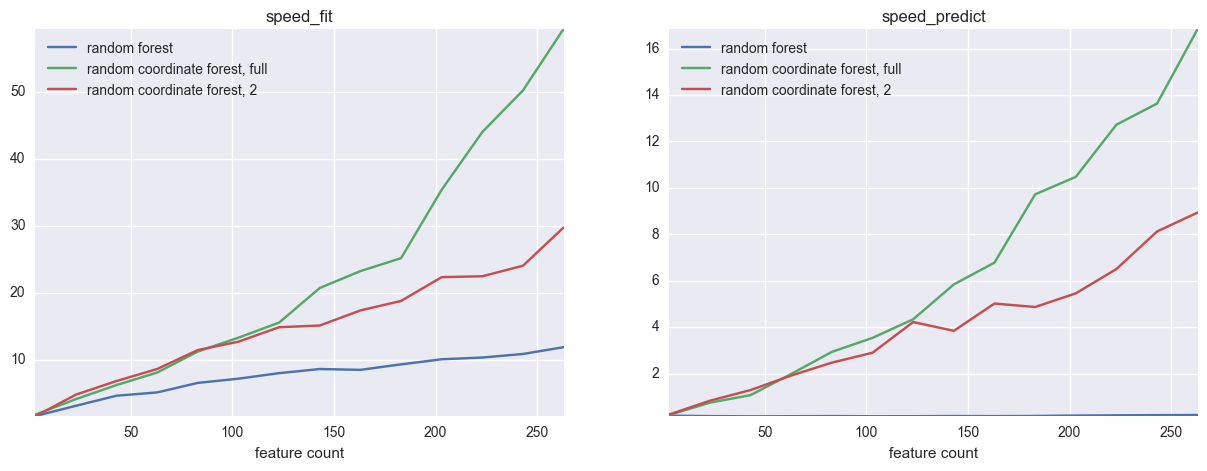

In [14]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)

plot_name(ax[0], 'speed_fit')
plot_name(ax[1], 'speed_predict')

As can be seen in the left graph above, the full random coordinate forest's cubic complexity really becomes a problem as the feature count gets much above 100. 

On the right, we see that prediction speed also gets out of hand. Unfortunately, both methods perform worse for prediction than the traditional random forest, in which prediction speed does not vary significantly with number of features. For many applications though, this is a nonissue.

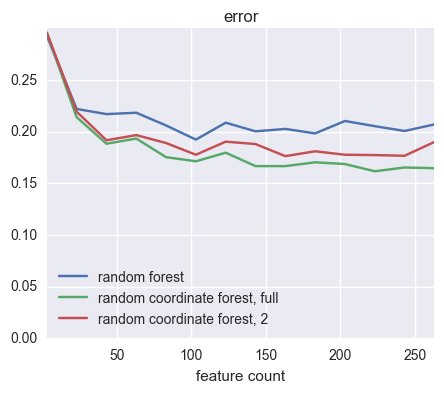

In [15]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 4)
ax.set_ylim(0, 0.3)
plot_name(ax, 'error', loc='lower left')

As you can see in the above graph, both the full random coordinate forest and the reduced version with 2 dimensional changes are more accurate than the traditional random forest. However, it looks like there is still a substantial difference between the full and reduced random coordinate forest.

# Future work

There are lots of things I'd like to do in the future with this, including:

* Test it for regression problems.

* See how well it works for gradient boosting, in particular with XGBoost or LightGBM.

* See how well it works for predictors other than tree ensembles.

* Improve the speed -- in particular, I've got some ideas that may allow the improved performance of the reduced coordinate forest while maintaining the accuracy of the full coordinate forest.

* Derive some theoretical results.